In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.utils.extmath import softmax
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('../src')  # Go one level up and then into src
from SMF import SMF_BCD

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [3]:
### Change the dimension of y for SMF_BCD
y_matrix = np.zeros((9, y.shape[0]))
for i in range(y.shape[0]):
    label = int(y[i])
    if label == 0:
        continue
    else:
        y_matrix[label-1, i] = 1

print(y_matrix.shape)
    

(9, 70000)


In [4]:
### Scale the input data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)

X= scaler.transform(X)

print(X.shape)

(70000, 784)


In [5]:
n_components = 16

SMF_Train = SMF_BCD([X.T, y_matrix], X_test=[X.T, y_matrix], xi= 5, n_components=n_components)

results_dict = SMF_Train.fit(iter=100, subsample_size=None,# search_radius_const=200*np.linalg.norm(X),
                                if_compute_recons_error=False, if_validate=False, threshold=0.5)

initial loading beta [[-0.72515189  0.81737788 -0.71314338  0.15521761  0.29733303 -0.74470902
  -0.44021977 -0.29319745 -0.17268705  0.59306242 -0.09466123 -0.24844446
  -0.99488946  0.49896992 -0.75560311  0.38479811 -0.93941394]
 [-0.68221235  0.36986066 -0.48747967 -0.23792872 -0.20693421  0.34177645
   0.18948377  0.67106021 -0.06630967 -0.97477224  0.74832253  0.01416032
   0.60826519 -0.98483497 -0.78880382 -0.4023836  -0.12788491]
 [ 0.73178439  0.89006744 -0.11052032 -0.07711597  0.49492949 -0.81612195
  -0.98489411 -0.52932858 -0.00798015  0.31372957  0.78331828 -0.49177902
  -0.74856449  0.01840479  0.54852732  0.71624149 -0.86724639]
 [ 0.55924502 -0.45172397  0.15034115 -0.93672694  0.04714666  0.68245642
   0.04808981 -0.71822325 -0.23628276  0.99256212 -0.50304282  0.21792785
  -0.53100767 -0.53111127 -0.48794543  0.60207145  0.29905317]
 [-0.62634697 -0.92470122 -0.99060806  0.69835369  0.37655449  0.61633678
  -0.81934354 -0.67499961 -0.10401797  0.50839034 -0.63179053

100%|██████████| 100/100 [08:00<00:00,  4.80s/it]
/Users/yee/miniforge3/envs/REU2024/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


!!! pred_type filter


In [10]:
W = results_dict.get('loading')[0]
beta= results_dict.get('loading')[1]
H = results_dict.get('code')

In [11]:
n = np.random.randint(0, 70000, size=100)
X_test = np.ones((X.shape[1], 100))
y_test = np.ones(shape=100)
for i in range(100):
    X_test[:, i] = X.T[:, n[i]]
    y_test[i] = y[n[i]]

p = np.zeros((100, 9))
for i in range(100):
    normalizer = 1 + np.sum(np.exp(beta[:, 1:] @ W.T @ X_test[:, i] + beta[:, 0]))
    p[i] = (np.exp(beta[:, 1:] @ W.T @ X_test[:, i] + beta[:, 0]) / normalizer).T


acc = 0
for j in range(100):
    prob = np.max(p[j])
    number = np.argmax(p[j]) + 1
    if (1 - np.sum(p[j])) > prob:
        number = 0
    if y_test[j] == number:
        acc += 1

print(f"The accuracy rate: {acc/100}")


The accuracy rate: 0.89


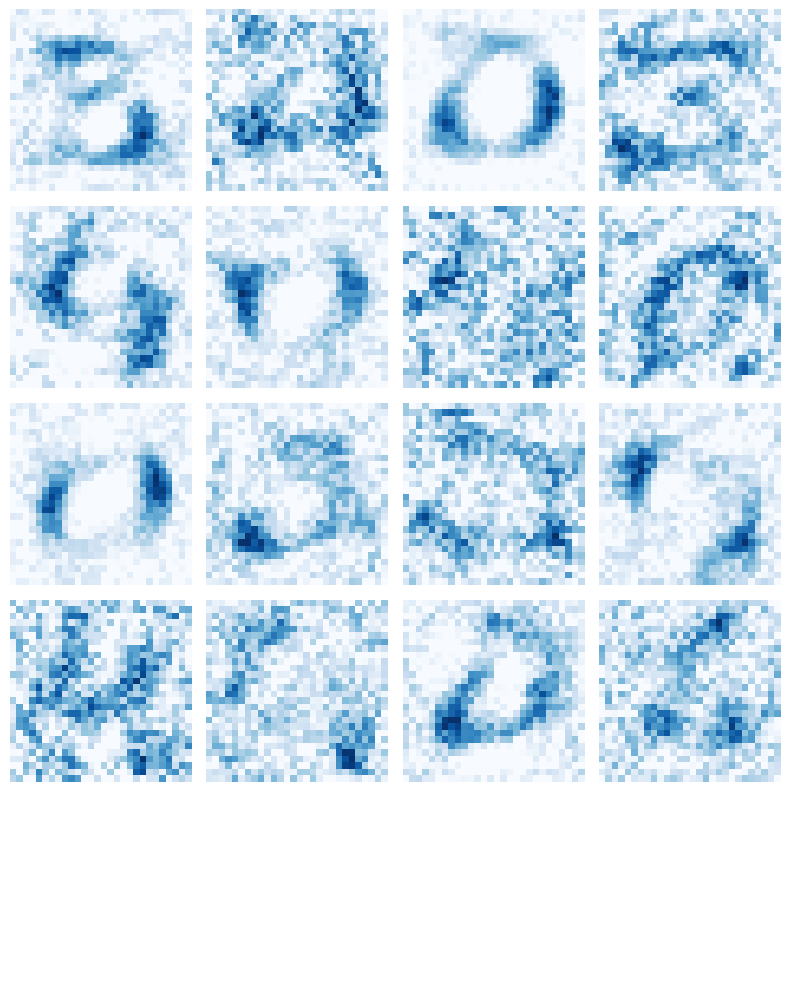

In [14]:
image = np.zeros((n_components, 28, 28))
for i in range(n_components):
    image[i] = W[:, i].reshape(28,28)

images_per_row = 4
n_rows = len(image) // images_per_row + 1

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=images_per_row, figsize=(images_per_row * 2, n_rows * 2))

for i, ax in enumerate(axes.flat):
    if i < n_components:
        # Reshape and display each component as an image
        ax.imshow(image[i], cmap='Blues')  # Use gray scale color map
        ax.axis('off')  # Hide axes
    else:
        ax.axis('off')  # Hide axes for empty subplots

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("MINIST")

# Display the plot if needed
plt.show()

In [13]:
print(beta.T[0])

[-8.37451205  1.07817752  0.73084603 -1.03527696  1.60882836 -0.85834435
 -1.53816862  2.47508355 -0.57196613]
